<a href="https://colab.research.google.com/github/Alexanderdivv/my-libOnPython/blob/intro/Watershed2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

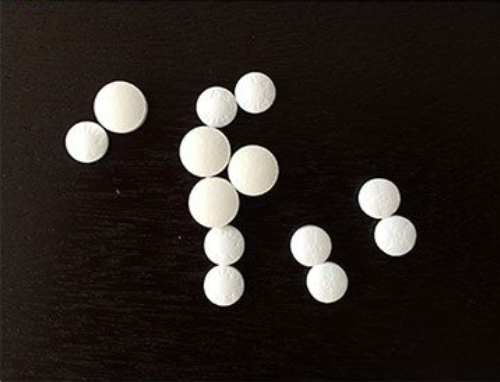

In [45]:
from google.colab.patches import cv2_imshow
img = cv2.imread("1.png")
cv2_imshow(img)

In [46]:
cells = img[:,:,0]

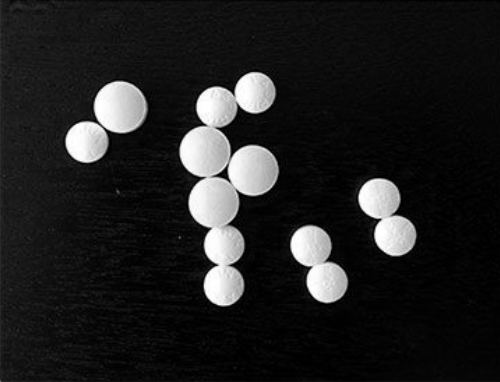

In [47]:
cv2_imshow(cells)

In [48]:
pixels_to_um = 0.454 

In [49]:
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

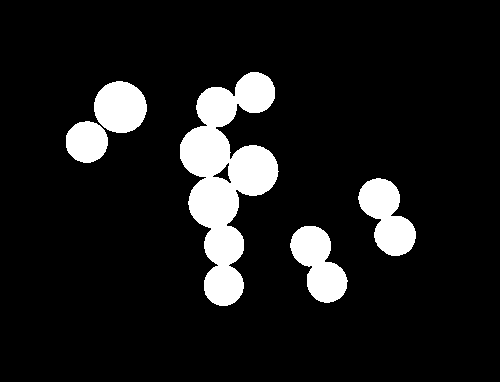

In [50]:
cv2_imshow(thresh)

In [51]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

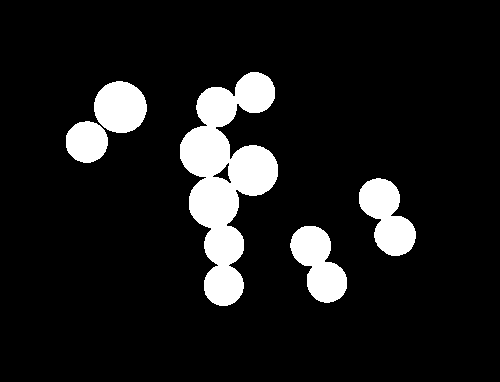

In [52]:
cv2_imshow(opening)

In [53]:
from skimage.segmentation import clear_border
opening = clear_border(opening)

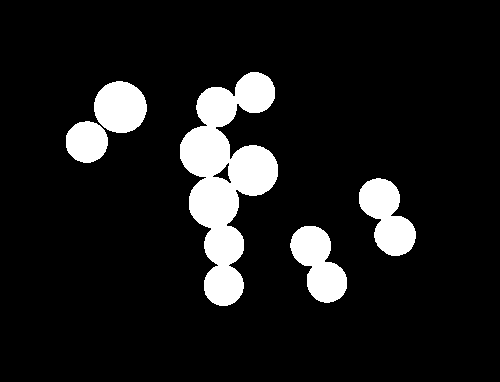

In [54]:
cv2_imshow(opening)

In [55]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)

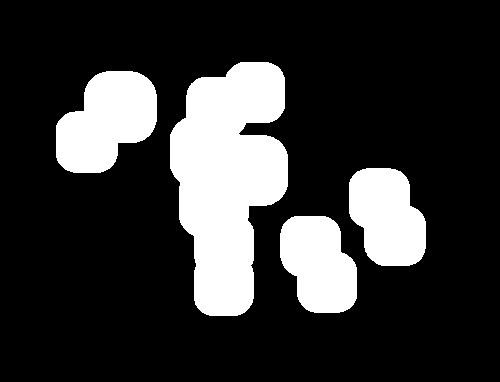

In [56]:
cv2_imshow(sure_bg)

In [57]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

In [58]:
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

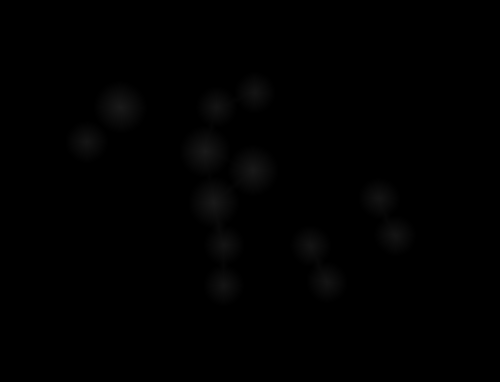

In [59]:
cv2_imshow(dist_transform)

In [60]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

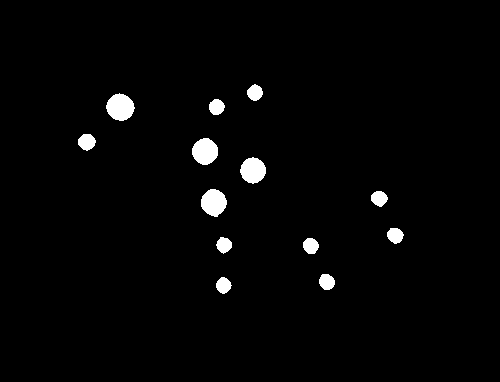

In [61]:
cv2_imshow(sure_fg)

In [62]:
ret3, markers = cv2.connectedComponents(sure_fg)

In [63]:
markers = markers+10

In [64]:
markers[unknown==255] = 0

In [65]:
markers = cv2.watershed(img,markers)

In [66]:
img[markers == -1] = [0,255,255]  

In [67]:
img2 = color.label2rgb(markers, bg_label=0)

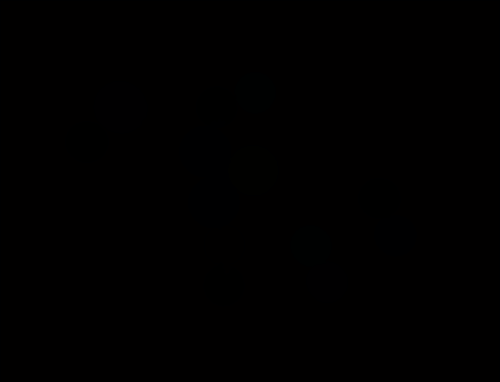

In [68]:
cv2_imshow(img2)

In [24]:
regions = measure.regionprops(markers, intensity_image=cells)

#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

Label: 10 Area: 168309
Label: 11 Area: 1247
Label: 12 Area: 2083
Label: 13 Area: 1175
Label: 14 Area: 1327
Label: 15 Area: 2167
Label: 16 Area: 1929
Label: 17 Area: 1965
Label: 18 Area: 1276
Label: 19 Area: 1259
Label: 20 Area: 1256
Label: 21 Area: 1261
Label: 22 Area: 1244
Label: 23 Area: 1195


In [25]:
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('cell_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

120

In [26]:
for region_props in regions:
    #output cluster properties to the excel file
    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')

In [28]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://www.youtube.com/watch?v=AsTvGxuiqKs



"""
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html

This code performs cell counting and size distribution analysis and dumps results into a csv file.
It uses watershed segmentationfor better segmentation.
Similar to grain analysis except here we segment cells. 
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

img = cv2.imread("source.jpg")
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.


pixels_to_um = 0.454 # 1 pixel = 454 nm (got this from the metadata of original image)

#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

from skimage.segmentation import clear_border
opening = clear_border(opening) #Remove edge touching grains
#Check the total regions found before and after applying this. 

#Now we know that the regions at the center of cells is for sure cells
#The region far away is background.
#We need to extract sure regions. For that we can use erode. 
#But we have cells touching, so erode alone will not work. 
#To separate touching objects, the best approach would be distance transform and then thresholding.

# let us start by identifying sure background area
# dilating pixes a few times increases cell boundary to background. 
# This way whatever is remaining for sure will be background. 
#The area in between sure background and foreground is our ambiguous area. 
#Watershed should find this area for us. 
sure_bg = cv2.dilate(opening,kernel,iterations=10)

# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#Let us threshold the dist transform by starting at 1/2 its max value.
#print(dist_transform.max()) gives about 21.9
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
ret3, markers = cv2.connectedComponents(sure_fg)

#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)
#The boundary region will be marked -1
#https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#Let us color boundaries in yellow. 
img[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

#cv2.imshow('Overlay on original image', img)
#cv2.imshow('Colored Grains', img2)
#cv2.waitKey(0)

#Now, time to extract properties of detected cells
# regionprops function in skimage measure module calculates useful parameters for each object.
regions = measure.regionprops(markers, intensity_image=cells)

#Can print various parameters for all objects
for prop in regions:
    print('Label: {} Area: {}'.format(prop.label, prop.area))

#Best way is to output all properties to a csv file
#Let us pick which ones we want to export. 

propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('cell_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for region_props in regions:
    #output cluster properties to the excel file
    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')

Label: 10 Area: 49595
Label: 11 Area: 565
Label: 12 Area: 520
Label: 13 Area: 637
Label: 14 Area: 83
Label: 15 Area: 615
Label: 16 Area: 73
